In [124]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import yfinance as yf
import scipy.optimize
from scipy import stats

In [125]:
# Define the ticker and the date range
ticker = '^GSPC'
start_date = '2014-01-01'
end_date = '2022-01-01'
riskless_return = 0.01  # Annualized risk-free rate
riskless_return_daily = riskless_return/250

# Download the data from Yahoo Finance
stock_data = yf.download(ticker, start=start_date, end=end_date)['Adj Close']

# Extract the returns
returns = stock_data.pct_change().dropna()  # Daily returns
returns = np.insert(returns.values, 0, 0)
# Display the first few rows of returns
print(returns)
# Sample size M
M = len(stock_data)
N = 1000
T = 100
num_intervals = 11




[*********************100%***********************]  1 of 1 completed

[ 0.         -0.00033297 -0.00251177 ...  0.0014019  -0.00298976
 -0.00262618]


1a:
Construct and back-test the dynamic strategy that maximizes E[(WT(α)^ζ)/ζ] over all strategies α = (α0, . . . , αT−1). 

The model for the risky return is Rt = µ + εt,
with i.i.d. {εt} t=1,...T s.t.
εt = σ, prob. 1/2,
    −σ, prob. 1/2,

where µ and σ should be approximated via the sample mean and the sample standard deviation of the returns of the risky asset (over each estimation window).

Plot the PnL process of this strategy. Print the annualized mean, standard deviation and the Sharpe ratio of the returns of the generated wealth process.
In parts b and c, it makes a difference what initial values of the “weights before rebalancing” you use at the beginning of each trading window. While other choices are possible, herein, you need to assume that the initial “weights before rebalancing” at the beginning of a trading window are given by the weights obtained at the end of the previous window.

In [127]:
def optimal_alpha(rf, mu, sigma):
    rfr = 1 + rf
    pos = mu + sigma - rf
    neg = mu - sigma - rf
    
    
    num =  rfr * (1 - ((-neg/pos) ** (-1/4)))
    den = neg * ((-neg/pos) ** (-1/4)) - pos
    alpha = num/den
    return [1 - alpha, alpha]

Model Parameters:
[[0.00040937734771698996, 0.007631509138734024], [0.0003873406309057243, 0.008080459358464426], [0.0004562978476823071, 0.007958010431403352], [0.0003436059054252223, 0.008608978588161932], [0.000402595219877154, 0.00861490825256603], [0.00047310131804197705, 0.008137452795727317], [0.00041175660518208136, 0.012309801481483681], [0.0005300430570737597, 0.012747867589873074], [0.0005639471255083396, 0.013052307293519017], [0.0006560863709443737, 0.013224955823040677], [0.0006548364527458797, 0.013375323806041322]]
Optimal Weights:
[[-0.5877409956987221, 1.587740995698722], [-0.331351122254377, 1.331351122254377], [-0.6459696666316368, 1.6459696666316368], [-0.024868928011877234, 1.0248689280118772], [-0.22267556115014298, 1.222675561150143], [-0.6378071548004272, 1.6378071548004272], [0.386327212182231, 0.613672787817769], [0.24546784018774204, 0.754532159812258], [0.23040155647446448, 0.7695984435255355], [0.11825873289022493, 0.8817412671097751], [0.13974928022199407

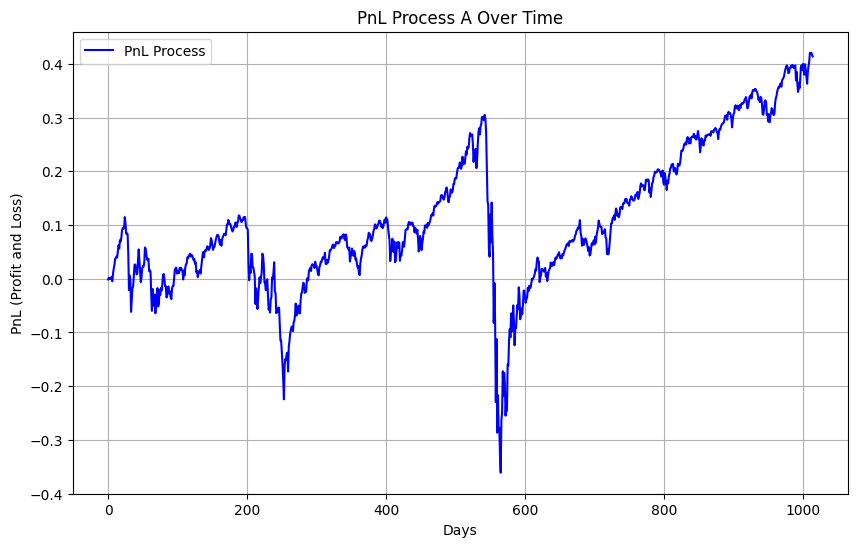

In [128]:
 
model_parameters = []
optimal_weights = []
portfolio_returns = []
pnl_process = []
for i in range(0, num_intervals):
    start_index = 1 + (100 * i)
    sample_data = returns[start_index:start_index+1000]
    sample_mean = sample_data.mean()
    sample_std = sample_data.std()
    model_parameters.append([sample_mean,sample_std])
    optimal_weights.append(optimal_alpha(riskless_return_daily,model_parameters[i][0],model_parameters[i][1]))
print("Model Parameters:")
print(model_parameters)
print("Optimal Weights:")
print(optimal_weights)

for i in range(0, num_intervals):
    start_index = 1000 + (100 * i)
    
    if i == 10:
        for j in range(start_index, start_index + 15):
            portfolio_returns.append((riskless_return_daily * optimal_weights[i][0]) + (returns[j] * optimal_weights[i][1]))
    else:
        for j in range(start_index, start_index + 100):
            portfolio_returns.append((riskless_return_daily * optimal_weights[i][0]) + (returns[j] * optimal_weights[i][1]))

wealth_process = np.cumprod(1 + np.array(portfolio_returns))

annualized_mean = 250 * np.mean(portfolio_returns)
annualized_std = math.sqrt(250) * np.std(portfolio_returns)
sharpe_ratio = (annualized_mean - riskless_return)/annualized_std

print("Portfolio Returns:")
print(portfolio_returns)


print(f"Annualized Mean of the Portfolio: {annualized_mean.item():.4f}")
print(f"Annualized Standard Deviation of Optimal Portfolio: {annualized_std:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


# Calculate the PnL process (Wealth - Initial wealth of 1)
pnl_process = wealth_process - 1

# Plot the PnL process
plt.figure(figsize=(10, 6))
plt.plot(pnl_process, label='PnL Process', color='blue')
plt.title('PnL Process A Over Time')
plt.xlabel('Days')
plt.ylabel('PnL (Profit and Loss)')
plt.grid(True)
plt.legend()
plt.show()


(b) (4 pts) Using the exact strategy computed in part (a), construct its PnL process
in the presence of proportional transaction costs of size λ = 0.02. This means
that at each time step if before trading, the current wealth is ω, fractions of
wealth in the risky asset is a and the target fraction of wealth in the risky asset
is α. Then, the amount λω|a−α| is paid as a transaction cost. Plot the resulting
PnL process. Print the annualized mean, standard deviation and the Sharpe ratio
of the returns of the generated wealth process

Portfolio Returns B:
[-0.03309281  0.0031292  -0.00075096 ...  0.00121157 -0.00256635
 -0.00225358]
Annualized Mean of the Portfolio B: 0.1090
Annualized Standard Deviation of Optimal Portfolio B: 0.3049
Sharpe Ratio B: 0.3248


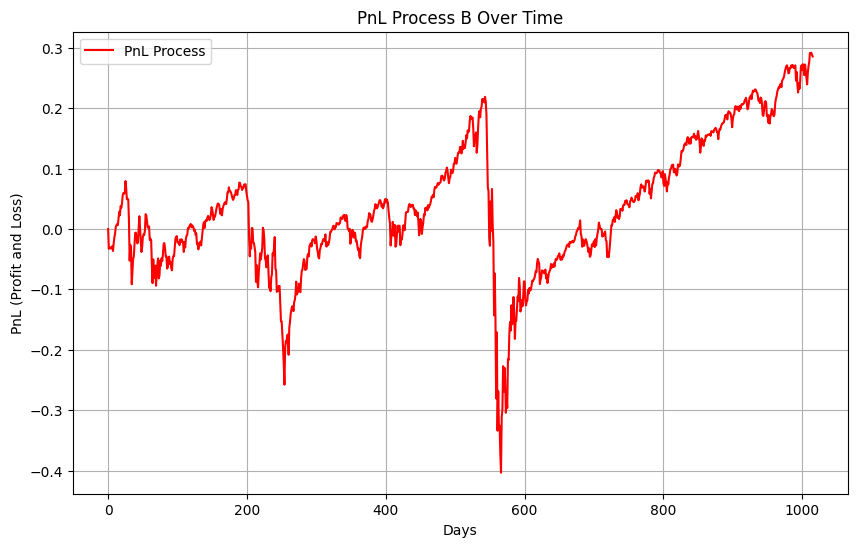

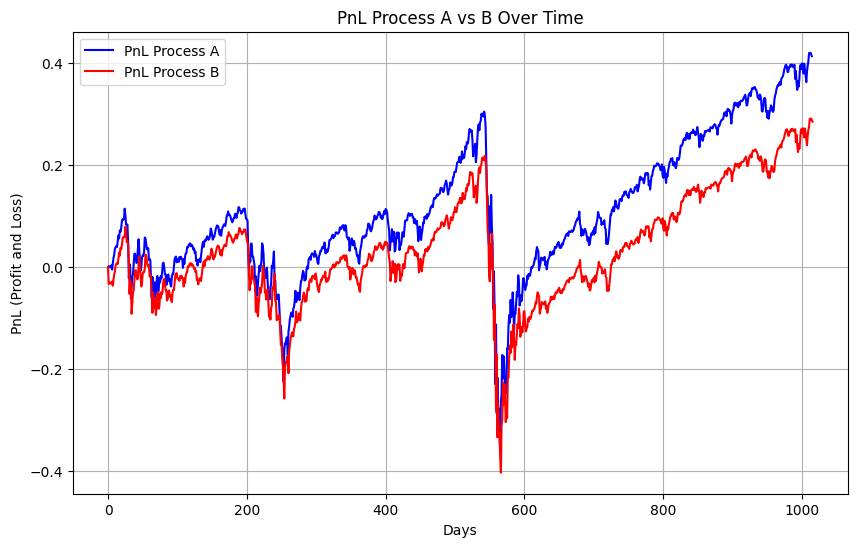

In [133]:
wealth_process_B = [1]
lambda_cost = 0.02
a_current = 0.0


for i in range(0, num_intervals):
    start_index = 1000 + (100 * i)
    if i == 10:
        for j in range(start_index, start_index + 15):
            # Calculate portfolio return without transaction cost
            port_return = (riskless_return_daily * optimal_weights[i][0]) + (returns[j] * optimal_weights[i][1])
        
            # Calculate the current wealth before updating
            current_wealth = wealth_process_B[-1]
        
            # Target fraction of wealth in risky asset
            alpha_target = optimal_weights[i][1]
        
            # Transaction cost based on change in allocation
            transaction_cost = lambda_cost * current_wealth * abs(a_current - alpha_target)
        
            # Update wealth considering transaction costs and returns
            new_wealth = (1 + port_return) * current_wealth - transaction_cost
        
            # Append the new wealth to the wealth process
            wealth_process_B.append(new_wealth)
        
            # Update the current allocation fraction to the new target
            a_current = alpha_target

    else: 
        for j in range(start_index, start_index + 100):  # Process all days
            # Calculate portfolio return without transaction cost
            port_return = (riskless_return_daily * optimal_weights[i][0]) + (returns[j] * optimal_weights[i][1])
        
            # Calculate the current wealth before updating
            current_wealth = wealth_process_B[-1]
        
            # Target fraction of wealth in risky asset
            alpha_target = optimal_weights[i][1]
        
            # Transaction cost based on change in allocation
            transaction_cost = lambda_cost * current_wealth * abs(a_current - alpha_target)
        
            # Update wealth considering transaction costs and returns
            new_wealth = (1 + port_return) * current_wealth - transaction_cost
        
            # Append the new wealth to the wealth process
            wealth_process_B.append(new_wealth)
        
            # Update the current allocation fraction to the new target
            a_current = alpha_target


# Convert wealth process to numpy array
wealth_process_B = np.array(wealth_process_B)

portfolio_returns_B = np.diff(wealth_process_B) / wealth_process_B[:-1]

annualized_mean_B = 250 * np.mean(portfolio_returns_B)  # Mean of daily returns, annualized
annualized_std_B = math.sqrt(250) * np.std(portfolio_returns_B)  # Std of daily returns, annualized
sharpe_ratio_B = (annualized_mean_B - riskless_return) / annualized_std_B

print("Portfolio Returns B:")
print(portfolio_returns_B)


print(f"Annualized Mean of the Portfolio B: {annualized_mean_B.item():.4f}")
print(f"Annualized Standard Deviation of Optimal Portfolio B: {annualized_std_B:.4f}")
print(f"Sharpe Ratio B: {sharpe_ratio_B:.4f}")

# Calculate the PnL process (Wealth - Initial wealth of 1)
pnl_process_B = wealth_process_B - 1

# Plot the PnL process
plt.figure(figsize=(10, 6))
plt.plot(pnl_process_B, label='PnL Process', color='red')
plt.title('PnL Process B Over Time')
plt.xlabel('Days')
plt.ylabel('PnL (Profit and Loss)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the PnL process
plt.figure(figsize=(10, 6))
plt.plot(pnl_process, label='PnL Process A', color='blue')
plt.plot(pnl_process_B, label='PnL Process B', color='red')
plt.title('PnL Process A vs B Over Time')
plt.xlabel('Days')
plt.ylabel('PnL (Profit and Loss)')
plt.grid(True)
plt.legend()
plt.show()

1c: Repeat part (a) with proportional transaction costs of size λ = 0.02.
Note that, unlike part (b), here you need to find the optimal strategy in the
presence of transaction costs, as opposed to re-using the strategy computed in
part (a).
To compute the value function and the feedback optimal strategy via DPP, use
an equidistant grid on [−1, 2.5], consisting of 100 points, for the possible values
of the “weights before rebalancing”. To compute the value function and the
optimal strategy outside of the grid points, use linear interpolation between the
grid points and constant extrapolation outside of [−1, 2.5].
On the very first trading day in your sample, i.e. on day N, your capital is fully
invested in the riskless asset before rebalancing (i.e., right before you decide on
the optimal portfolio weights to be used at that time).
Plot the PnL process of this strategy. Print the annualized mean, standard deviation and Sharpe ratio of the returns of the generated wealth process

In [159]:
alpha_grid = np.linspace(-1,2.5,101)

def optimal_next_alpha(prev_alpha,prev_return,current_f, mu, sigma):
    current_f_interpolation = scipy.interpolate.interp1d(alpha_grid,current_f)

    def find_best_alpha(x):
        prev_rf_return = (1 - prev_alpha) * (1 + riskless_return_daily)
        prev_risky_return = prev_alpha * (1 + prev_return)
        prev_risky_weight = prev_risky_return / (prev_risky_return + prev_rf_return)
        trans_cost = 2 * lambda_cost * abs(prev_risky_weight - x)
        pos = 1 + x * (mu + sigma) + (1 - x) * riskless_return_daily - trans_cost
        neg = 1 + x * (mu - sigma) + (1 - x) * riskless_return_daily - trans_cost
        expectation = current_f_interpolation(x) * (pos ** -3 + neg ** -3)/2
        return expectation
    
    opt_alpha = scipy.optimize.minimize(fun = find_best_alpha, x0=0, bounds=((-1,2.5),))
    return(float(opt_alpha.x), opt_alpha.fun)

interval = 10
trading_indices = np.array([1000 + (100 * i) for i in range (0,num_intervals)])
trading_indices = np.hstack([trading_indices,2015])
alpha_f_tensor = np.zeros((1015,101,2))
return_prev = returns[2013]
alpha_f_tensor[0] = np.array([optimal_next_alpha(alpha, return_prev, [1] * 101, model_parameters[interval][0], model_parameters[interval][1]) for alpha in alpha_grid])

for i in range(1,1015):
    if 2014 - i < trading_indices[interval]:
        interval -= 1
    
    return_prev = returns[2013 - i]

    if i == 1014: 
        return_prev = 0
    
    current_alpha_prev_f = np.array([optimal_next_alpha(alpha, return_prev, alpha_f_tensor[i-1,:,1],model_parameters[interval][0],model_parameters[interval][1]) for alpha in alpha_grid])
    alpha_f_tensor[i] = current_alpha_prev_f
        
 

/var/folders/gc/w6t6ktt94hg5ckfj2nytpt0m0000gn/T/ipykernel_29471/1151142634.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return(float(opt_alpha.x), opt_alpha.fun)


In [160]:
initial_interpolation = scipy.interpolate.interp1d(alpha_grid, alpha_f_tensor[-1,:, 1])
W_1 = 1
alpha_0 = 0
V_1 = -(W_1 ^ -3) * initial_interpolation(alpha_0)/3
V_1

0.6981300597559802

In [162]:
alpha_prev = 0
opt_weights_trans_cost = []
for i in range(1, 1016):
    alpha_interpolation = scipy.interpolate.interp1d(alpha_grid, alpha_f_tensor[-i, :, 0])
    alpha_current = float(alpha_interpolation(alpha_prev))
    opt_weights_trans_cost.append(alpha_current)
    alpha_prev = alpha_current

opt_weights_trans_cost = np.array(opt_weights_trans_cost)
opt_weights_trans_cost = np.transpose(np.vstack([1 - opt_weights_trans_cost, opt_weights_trans_cost]))
opt_weights_trans_cost

array([[0.56499994, 0.43500006],
       [0.28500001, 0.71499999],
       [0.10999988, 0.89000012],
       ...,
       [0.02981658, 0.97018342],
       [0.02977758, 0.97022242],
       [0.0298646 , 0.9701354 ]])

In [172]:
wealth_with_trans_costs = [1] * 1016
returns_with_trans_costs = [0] * 1015
weights_prev2 = [1, 0]
weights_prev = opt_weights_trans_cost[0]

for index in range(1, 1016):
    stock_return = returns[index + 999]
    stock_return_prev = returns[index + 998]

    if index == 1:
        A_numer_riskfree = 1
        A_numer_risky = 0
    else:
        A_numer_riskfree = weights_prev2[0] * (1 + riskless_return_daily)
        A_numer_risky = weights_prev2[1] * (1 + stock_return_prev)
    weights_before_rebalancing = np.array([A_numer_riskfree/(A_numer_riskfree + A_numer_risky), A_numer_risky/ (A_numer_riskfree + A_numer_risky)])
    
    trans_cost = lambda_cost * np.sum(np.abs(weights_prev - weights_before_rebalancing))
    wealth_with_trans_costs[index] = wealth_with_trans_costs[index - 1] * (1 + weights_prev[0] * riskless_return_daily + weights_prev[1] * returns[index + 999] - trans_cost)
    returns_with_trans_costs[index - 1] = (wealth_with_trans_costs[index] - wealth_with_trans_costs[index - 1])/wealth_with_trans_costs[index - 1]

    if index < 1015:
        weights_prev2 = weights_prev
        weights_prev = opt_weights_trans_cost[index]

wealth_with_trans_costs = np.array(wealth_with_trans_costs)
returns_with_trans_costs = np.array(returns_with_trans_costs)

pnl_process_C = wealth_with_trans_costs - 1


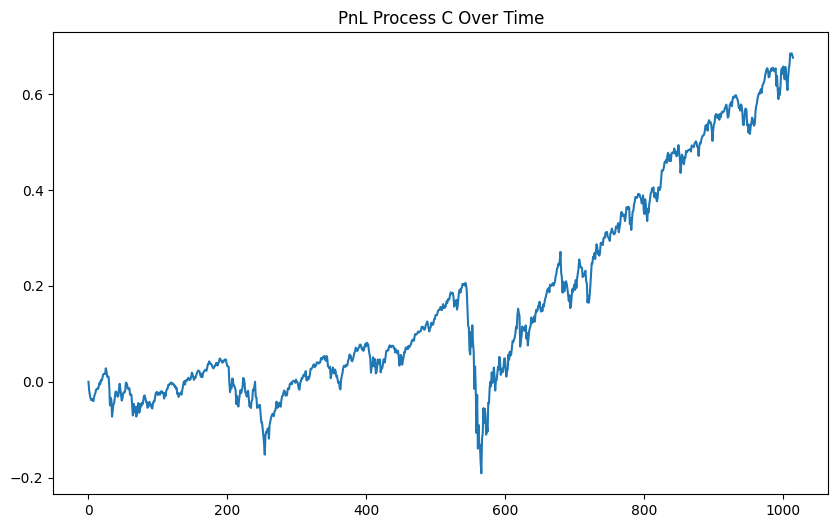

In [173]:
fig = plt.figure(figsize = (10, 6))
plt.plot(pnl_process_C)
plt.title("PnL Process C Over Time")
plt.show()

In [174]:
annualized_mean_C = 250 * np.mean(returns_with_trans_costs)
annualized_std_C = math.sqrt(250) * np.std(returns_with_trans_costs, ddof = 1)
sharpe_ratio_C = (annualized_mean_C - riskless_return)/annualized_std_C

print(f"Annualized Mean of the Portfolio C: {annualized_mean_C.item():.4f}")
print(f"Annualized Standard Deviation of Optimal Portfolio C: {annualized_std_C:.4f}")
print(f"Sharpe Ratio C: {sharpe_ratio_C:.4f}")

Annualized Mean of the Portfolio C: 0.1480
Annualized Standard Deviation of Optimal Portfolio C: 0.2033
Sharpe Ratio C: 0.6788


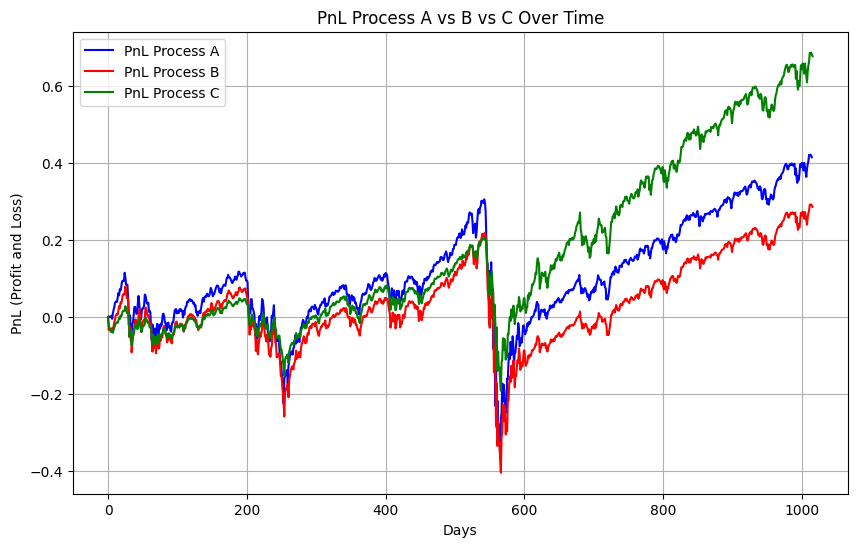

In [175]:
# Plot the PnL process
plt.figure(figsize=(10, 6))
plt.plot(pnl_process, label='PnL Process A', color='blue')
plt.plot(pnl_process_B, label='PnL Process B', color='red')
plt.plot(pnl_process_C, label='PnL Process C', color='green')
plt.title('PnL Process A vs B vs C Over Time')
plt.xlabel('Days')
plt.ylabel('PnL (Profit and Loss)')
plt.grid(True)
plt.legend()
plt.show()